# **Implementation of GP-SARSA and its Relaxations**
## *Vardaan Tekriwal*

## 1. Introduction


Based on Engel et al. (2005), GP-SARSA offers key advantages over traditional Reinforcement Learning methods SARSA and TD by leveraging Gaussian Processes to generalize across state-action spaces without discretization, **particularly excelling in environments with continuous or large state-action spaces**. It provides both Q-value predictions and uncertainty estimates, enhancing exploration through uncertainty-guided strategies. Unlike traditional methods, GP-SARSA handles stochastic environments robustly and supports model-free policy improvement using Bayesian inference. Its kernel-based approach encodes prior knowledge and prevents overfitting by smoothing noisy data. Implementing kernel sparsification ensures computational efficiency by maintaining a compact representation of state-action pairs – instead of storing each (s, a) pair, we maintain a dictionary inclusive only of pairs that are sufficiently dis-similar (w.r.t. the kernel function).

However, GP-SARSA makes assumptions that are **not** trivial for some environments. Regarding uncertainty in the environment – it decomposes uncertainty into two buckets, intrinsic and extrinsic. For intrinsic uncertainty, which arises from the stochastic nature of state transitions and rewards, it assumes that values (i.e. rewards) are corrupted by zero-mean Gaussian noise and that residual errors (differences between predicted and actual values) across different transitions are independent. This assumption ensures that the uncertainty due to randomness in the environment can be modeled as a Gaussian process with tractable posterior updates. For extrinsic uncertainty, which stems from incomplete knowledge of the underlying MDP, it assumes that the Q-function follows a Gaussian process prior, representing the agent's subjective uncertainty about the true value function. This extrinsic uncertainty is captured through a well-defined kernel function that encodes correlations between state-action pairs, reflecting prior beliefs about the problem structure.



## 2. Environment

In [5]:
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns

The following notebook sets up a 2D stochastic maze environment, where the task involves designing a two-dimensional continuous environment within the unit square for a reinforcement learning agent solving a maze navigation problem. The agent takes steps of 0.1 units in any direction (so the action space is the unit circle) and receives a negative reward of -1 at each timestep until it reaches the goal. Hitting an obstacle returns the agent to its original position. 

The stochasticity is divided into two parts – intrinsic and extrinsic uncertainties. The intrinsic uncertainties in the maze environment include reward noise and action noise. Reward noise arises from adding Gaussian perturbations to the base reward, making the observed reward uncertain. Action noise introduces randomness by applying a random rotational disturbance (up to ±36 degrees) to the agent’s intended direction, leading to deviations in movement. Extrinsic uncertainties are in state observation noise, where the agent receives a noisy version of its true position, with Gaussian noise added to the actual state.

It implements a GP-SARSA reinforcement learning agent that uses Gaussian Processes with an evolving dictionary of state-action pairs to learn a Q-value function under uncertainty. The agent explores the maze using epsilon-greedy or variance-based strategies, updates its Q-function based on the temporal difference error, and grows its dictionary for novel experiences. Additionally, the code includes visualization tools to track training progress, plot trajectories, value and variance maps, and eventually display a learned vector field policy over the maze.



In [6]:
################################################################################
#                         MazeEnvironment WITH UNCERTAINTIES                   #
################################################################################
class MazeEnvironment:
    """
    Maze environment in a [0,1]^2 domain with:
      1) Circular obstacles
      2) A goal region
      3) Intrinsic uncertainty: reward noise
      4) Intrinsic uncertainty: action noise
      5) Extrinsic uncertainty: state observation noise

    """
    def __init__(self, obstacles: List[Tuple[float, float, float]], 
                 goal: Tuple[float, float, float],
                 reward_noise_std: float = 0.1,
                 state_obs_noise_std: float = 0.02):
        """
        obstacles: list of (x, y, radius)
        goal: (x, y, radius)
        reward_noise_std: standard deviation for reward noise (intrinsic)
        state_obs_noise_std: standard deviation for observed state noise (extrinsic)
        """
        self.obstacles = obstacles
        self.goal = goal
        
        # Movement and noise settings
        self.step_size = 0.1
        self.angle_noise = np.pi / 5   # ±36 degrees, a bit bigger than ±30
        self.reward_noise_std = reward_noise_std
        self.state_obs_noise_std = state_obs_noise_std

        # Internal state
        self.state = None  # True position in the environment

    def reset(self) -> np.ndarray:
        """
        Reset the environment to a random valid position (true state).
        Return a noisy observation of that state (extrinsic uncertainty).
        """
        while True:
            candidate = np.random.rand(2)  # uniform in [0,1]^2
            if self.is_valid_position(candidate):
                self.state = candidate
                break
        return self.get_noisy_observation()

    def step(self, obs: np.ndarray, action: np.ndarray) -> Tuple[np.ndarray, float, bool]:
        """
        The agent provides the last OBSERVATION and an ACTION (2D unit vector).
        We do:
         1) Convert obs -> state (we store it internally from last step)
         2) Add random angle noise (intrinsic uncertainty in action)
         3) Move the agent, check collisions
         4) Add random reward noise
         5) Return new OBSERVATION (extrinsic uncertainty), reward, done
        """
        # The environment internally tracks the "true" state (self.state).
        # The agent only sees 'obs' which is a noisy version. We do not actually
        # correct the environment's internal state with 'obs' because
        # the environment "knows" the real position.

        # 1) Add random rotation to the action
        angle = np.arctan2(action[1], action[0])
        angle += np.random.uniform(-self.angle_noise, self.angle_noise)
        noisy_action = np.array([np.cos(angle), np.sin(angle)])

        # 2) Attempt to move
        next_state = self.state + self.step_size * noisy_action
        if not self.is_valid_position(next_state):
            next_state = self.state.copy()

        self.state = next_state  # update environment's internal state

        # 3) Reward: 0 if goal, else -1, plus noise
        done = self.is_goal(self.state)
        base_reward = 0.0 if done else -1.0
        reward = base_reward + np.random.randn() * self.reward_noise_std

        # 4) Return new observation of the internal state
        return self.get_noisy_observation(), reward, done

    def is_valid_position(self, pos: np.ndarray) -> bool:
        """Check that pos is in [0,1]^2 and not within an obstacle."""
        if not (0 <= pos[0] <= 1 and 0 <= pos[1] <= 1):
            return False
        for ox, oy, r in self.obstacles:
            if np.sqrt((pos[0]-ox)**2 + (pos[1]-oy)**2) < r:
                return False
        return True

    def is_goal(self, pos: np.ndarray) -> bool:
        """Check if pos is inside the goal region."""
        gx, gy, gr = self.goal
        return np.sqrt((pos[0]-gx)**2 + (pos[1]-gy)**2) < gr

    def get_noisy_observation(self) -> np.ndarray:
        """
        Return a noisy version of the true internal state (extrinsic uncertainty).
        """
        obs = self.state + np.random.randn(2) * self.state_obs_noise_std
        return obs


## 3. Agents

The following classes depict two agents – one is a simplified version of GP-SARSA, where we take the liberty to speed up computation as we disregard heavy calculations. Naturally, we will not yield the optimal results, though we obtain approximates sufficiently accurate for the purposes of illustration. We provide a vanilla RBF kernel for both the action and state kernels. All remaining assumptions, relaxations, and deviations are noted in the comments. 

We then provide a complete code that can be used to put the GP-SARSA algorithm into practice, though we note that the action space is relaxed (since for the example at hand, the results should be near-optimal). No pre-specified kernel is provided, we assume the user will define a kernel most applicable to their environment. The fully rigorous version implements a conceptually easy, a basic optimization, but numerically challenging. For higher dimensions, the tradeoff is worth it.

In [96]:
################################################################################
#                                GP-SARSA AGENT                                #
################################################################################
class GPSARSAAgent:
    """
    GP-SARSA agent with:
      - Dictionary for kernel expansions
      - On-line incremental updates
      - Epsilon-greedy or max-variance exploration

    NOTE: This version does not implement the full Engel et al. matrix-based
    GP-SARSA updates. Instead, it uses a simpler "TD-like" kernel approach:

      1) Q(s,a) ~ k(s,a)^T * alpha
      2) Var(s,a) ~ 1 - k(s,a)^T * k(s,a)
      3) TD error: delta = r + gamma*Q(s',a') - Q(s,a)
      4) alpha <- alpha + lr * delta * k(s,a)

    See inline comments below for where it departs from the formal algorithm.
    """

    def __init__(self, 
                 state_kernel_bandwidth: float = 0.1, 
                 action_kernel_bandwidth: float = 0.5,
                 dict_threshold: float = 0.1,
                 learning_rate: float = 0.1,
                 discount_factor: float = 0.99,
                 epsilon: float = 0.1):
        
        self.state_kernel_bandwidth = state_kernel_bandwidth
        self.action_kernel_bandwidth = action_kernel_bandwidth
        self.dict_threshold = dict_threshold
        self.learning_rate = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon

        # Dictionary: list of (state, action)
        self.dictionary: List[Tuple[np.ndarray, np.ndarray]] = []
        
        # alpha is a simple weight vector, NOT the block-inverted matrix-based alpha
        # from the Engel algorithm. This is a main simplification.
        self.alpha = np.array([])  

        # Optional storage for visualizing the dictionary
        self.dictionary_states = []
    
    # ------------------ Kernel Functions ------------------ #
    def state_kernel(self, s1: np.ndarray, s2: np.ndarray) -> float:
        # RBF kernel for states
        dist_sq = np.sum((s1 - s2)**2)
        return np.exp(-dist_sq / (2 * self.state_kernel_bandwidth**2))

    def action_kernel(self, a1: np.ndarray, a2: np.ndarray) -> float:
        # RBF kernel for actions
        dist_sq = np.sum((a1 - a2)**2)
        return np.exp(-dist_sq / (2 * self.action_kernel_bandwidth**2))

    def kernel(self, s1: np.ndarray, a1: np.ndarray, s2: np.ndarray, a2: np.ndarray) -> float:
        # Combined kernel = state_kernel(s1, s2) * action_kernel(a1, a2)
        return self.state_kernel(s1, s2) * self.action_kernel(a1, a2)

    def get_kernel_vector(self, state: np.ndarray, action: np.ndarray) -> np.ndarray:
        # Evaluate kernel against all dictionary entries
        k = np.zeros(len(self.dictionary))
        for i, (s, a) in enumerate(self.dictionary):
            k[i] = self.kernel(state, action, s, a)
        return k

    # ------------------ Q-value and Variance --------------- #
    def get_q_value(self, state: np.ndarray, action: np.ndarray) -> float:
        """
        Q(s,a) = k(s,a)^T * alpha
        
        Simplification: The formal algorithm keeps a separate α for each
        dictionary expansion, updated by block inversion. Here we simply
        do a dot product with a single alpha vector.
        """
        if len(self.dictionary) == 0:
            return 0.0
        k_vec = self.get_kernel_vector(state, action)
        return np.dot(k_vec, self.alpha)

    def get_q_variance(self, state: np.ndarray, action: np.ndarray) -> float:
        """
        Approx. posterior variance = 1 - k(s,a)^T * k(s,a)
        
        This is another simplification: real GP-SARSA uses (K^-1) expansions
        to compute the posterior variance. Here it's just 1 - k·k.
        """
        if len(self.dictionary) == 0:
            return 1.0
        k_vec = self.get_kernel_vector(state, action)
        return 1.0 - np.dot(k_vec, k_vec)

    # ------------------ Action Selection ------------------- #
    def select_action(self, state: np.ndarray, mode: str = 'epsilon_greedy') -> np.ndarray:
        """
        In the original Engel framework, action selection often requires
        a search (gradient-based or sampling) in continuous spaces.
        Here, we discretize actions to 16 angles on a unit circle.
        """
        if mode == 'epsilon_greedy':
            if np.random.rand() < self.epsilon:
                # Explore: choose a random direction
                angle = np.random.uniform(0, 2 * np.pi)
                action = np.array([np.cos(angle), np.sin(angle)])
            else:
                # Exploit: find action with max Q value
                angles = np.linspace(0, 2 * np.pi, 16, endpoint=False)
                actions = np.column_stack((np.cos(angles), np.sin(angles)))
                q_values = [self.get_q_value(state, a) for a in actions]
                action = actions[int(np.argmax(q_values))]
        
        elif mode == 'variance':
            # A simplified "max variance" approach, not in the original Engel code
            if np.random.rand() < self.epsilon:
                angles = np.linspace(0, 2 * np.pi, 16, endpoint=False)
                actions = np.column_stack((np.cos(angles), np.sin(angles)))
                variances = [self.get_q_variance(state, a) for a in actions]
                # Note: there's a small bug: np.max(...) returns the max value, 
                # but not the index. Should be np.argmax(...). 
                # We'll assume it's meant to be np.argmax(...) for consistent logic.
                action = actions[int(np.argmax(variances))]
            else:
                angles = np.linspace(0, 2 * np.pi, 16, endpoint=False)
                actions = np.column_stack((np.cos(angles), np.sin(angles)))
                q_values = [self.get_q_value(state, a) for a in actions]
                action = actions[int(np.argmax(q_values))]
        
        else:
            raise ValueError("Unknown mode. Use 'epsilon_greedy' or 'variance'.")
        
        return action

    # ------------------ GP-SARSA Update -------------------- #
    def update(self, state: np.ndarray, action: np.ndarray, reward: float, 
               next_state: np.ndarray, next_action: np.ndarray, done: bool):
        """
        Simplified "TD-like" update. Formal Engel GP-SARSA would do:

          1) Compute a_t, delta_t, etc. from (K^-1) expansions
          2) Possibly expand dictionary if delta_t > threshold
          3) Update alpha, C, etc. via block matrix operations

        Here, we:
          - Check novelty by max(k_vec)
          - Do a basic TD error and gradient step in alpha
        """
        k_vec = self.get_kernel_vector(state, action)

        # Dictionary expansion: checks if max kernel overlap < threshold
        # Engel's approach uses δ_t = k(x,x)-k(x,·)^T K^-1 k(x,·). This is simpler.
        if len(self.dictionary) == 0 or np.max(k_vec) < self.dict_threshold:
            self.dictionary.append((state.copy(), action.copy()))
            self.dictionary_states.append(state.copy()) 
            # Because it's a new dictionary entry, we add the kernel with itself:
            k_vec = np.append(k_vec, [self.kernel(state, action, state, action)])
            self.alpha = np.append(self.alpha, [0.0])

        # TD target
        current_q = self.get_q_value(state, action)
        if done:
            target = reward
        else:
            next_q = self.get_q_value(next_state, next_action)
            target = reward + self.gamma * next_q
        td_error = target - current_q

        # "TD-like" update for alpha (no matrix inverse update)
        self.alpha += self.learning_rate * td_error * k_vec


#### Key Simplifications vs. Engel et al.:

1. **No inverse Gram matrix**  
   $\widetilde{K}_{t-1}$ is neither stored nor updated.

2. **No block expansions**  
   $\widetilde{C}_{t}$ is not expanded, and no separate $\widetilde{\alpha}_{t}$ is maintained.

3. **Dictionary novelty check**  
   Utilizes $\max_{k}(\cdot)$ instead of $\delta_{t}$.

4. **Variance calculation**  
   Uses $1 - k \cdot k$ rather than a Gaussian Process (GP) posterior formula.

5. **Action selection**  
   Achieved by discretizing angles instead of performing continuous optimization.


In [97]:
class FullGPSARSAAgent:
    def __init__(self, state_dim, action_dim, kernel_func, gamma, sigma2, nu):
        """
        Full implementation of GP-SARSA as described by Engel et al.
        
        Parameters:
        - state_dim: dimension of the state space
        - action_dim: dimension of the action space
        - kernel_func: function to compute the kernel value between two points
        - gamma: discount factor
        - sigma2: noise hyperparameter
        - nu: novelty threshold for dictionary expansion
        """
        self.state_dim = state_dim 
        self.action_dim = action_dim
        self.kernel_func = kernel_func
        self.gamma = gamma
        self.sigma2 = sigma2
        self.nu = nu

        # Dictionary to store (state, action) pairs
        self.D = []  # List of vectors of size (state_dim + action_dim,)
        
        # Initialize GP-SARSA variables (all initially empty)
        self.Kinv = None    # Inverse of the kernel matrix, shape (m, m)
        self.alpha = None   # Weight vector, shape (m,)
        self.C = None       # Covariance matrix, shape (m, m)
        self.c = None       # Intermediate vector, shape (m,)
        self.d = 0.0        # Scalar for reward accumulation
        self.s = 0.0        # Scalar for variance computation

        # Previous (state, action) pair and reward for TD error computation
        self.x_prev = None  # Vector of size (state_dim + action_dim,)
        self.r_prev = 0.0

        # Flag to indicate whether the agent has been initialized
        self.initialized = False

    def _kvec(self, x):
        """
        Compute the kernel vector k(x, D) where D is the current dictionary.
        
        Returns:
        - A vector of kernel values between x and each element in the dictionary D.
        Formula: kvec(x) = [k(x, x_1), k(x, x_2), ..., k(x, x_m)]
        
        Dimensions:
        - x: (state_dim + action_dim,)
        - kvec: (m,)
        """
        m = len(self.D)
        v = np.zeros(m)
        for i in range(m):
            v[i] = self.kernel_func(x, self.D[i])
        return v

    def _expand_Kinv(self, a, delta):
        """
        Expand the inverse kernel matrix Kinv using block-inversion.
        
        Parameters:
        - a: vector resulting from Kinv @ kvec (size m)
        - delta: novelty measure delta_t (scalar)
        
        Returns:
        - Expanded (m+1, m+1) inverse kernel matrix.
        Formula: 
        Kinv_new = [ Kinv + (a a^T) / delta   -a / delta ]
                   [    -a^T / delta             1/delta  ]
        
        Dimensions:
        - Kinv: (m, m)
        - a: (m,)
        - Kinv_new: (m+1, m+1)
        """
        m = self.Kinv.shape[0]
        Kinv_new = np.zeros((m+1, m+1))
        Kinv_new[:m, :m] = self.Kinv + np.outer(a, a) / delta
        Kinv_new[:m, m] = -a / delta
        Kinv_new[m, :m] = -a.T / delta
        Kinv_new[m, m] = 1.0 / delta
        return Kinv_new

    def _append_zero_rowcol(self, M):
        """
        Append a zero row and column to matrix M (used for expanding C).
        Formula: M_new = [ M   0 ]
                        [ 0^T 0 ]
        
        Dimensions:
        - M: (m, m)
        - M_new: (m+1, m+1)
        """
        r, c = M.shape
        M_new = np.zeros((r+1, c+1))
        M_new[:r, :c] = M
        return M_new

    def _append_zero(self, v):
        """
        Append a zero to the vector v (used for expanding alpha and c).
        Formula: v_new = [v, 0]
        
        Dimensions:
        - v: (m,)
        - v_new: (m+1,)
        """
        return np.append(v, 0.0)

    def _block_expansion(self, xt, delta_t, a_t):
        """
        Expand the dictionary and update all relevant variables when delta_t > nu.
        
        Parameters:
        - xt: the new (state, action) pair to be added to the dictionary
        - delta_t: the novelty measure
        - a_t: intermediate vector from Kinv @ kvec
        
        Formulae:
        - Update dictionary: D = D + {xt}
        - Kinv <- expanded using block-inversion
        - alpha <- [alpha, 0]
        - C <- [C   0]
               [0^T 0]
        - c <- [c, 0]
        
        Dimensions:
        - xt: (state_dim + action_dim,)
        - Kinv: (m+1, m+1)
        - alpha: (m+1,)
        - C: (m+1, m+1)
        - c: (m+1,)
        """
        self.D.append(xt.copy())  # Add new (state, action) to the dictionary
        self.Kinv = self._expand_Kinv(a_t, delta_t)  # Update inverse kernel matrix
        self.alpha = self._append_zero(self.alpha)   # Expand alpha by appending zero
        self.C = self._append_zero_rowcol(self.C)    # Expand C matrix
        self.c = self._append_zero(self.c)           # Expand c vector

    def _dict_novelty(self, xt):
        """
        Compute the novelty measure delta_t = k(x, x) - k(x)^T @ Kinv @ k(x).
        
        Returns:
        - delta_t: novelty measure (scalar)
        Formula: delta_t = k(xt, xt) - kvec(xt)^T @ Kinv @ kvec(xt)
        
        Dimensions:
        - xt: (state_dim + action_dim,)
        - delta_t: scalar
        """
        if self.Kinv is None:
            return self.kernel_func(xt, xt)
        kvec = self._kvec(xt)
        a = self.Kinv.dot(kvec)
        return self.kernel_func(xt, xt) - kvec.dot(a)

    def initialize(self, x0):
        """
        Initialize the agent with the first (state, action) pair.
        
        Formulae:
        - Kinv = [1 / k(x0, x0)]
        - alpha = [1]
        - C = [0]
        - c = [0]
        - d = 0
        - s = 0
        
        Dimensions:
        - x0: (state_dim + action_dim,)
        - Kinv: (1, 1)
        - alpha: (1,)
        - C: (1, 1)
        - c: (1,)
        - d: scalar
        - s: scalar
        """
        self.D = [x0.copy()]
        self.Kinv = np.array([[1.0 / self.kernel_func(x0, x0)]])
        self.alpha = np.array([1.0])
        self.C = np.zeros((1, 1))
        self.c = np.zeros((1,))
        self.d = 0.0
        self.s = 0.0
        self.x_prev = x0.copy()
        self.r_prev = 0.0
        self.initialized = True

    def update(self, rt, xt, done):
        """
        Update the GP-SARSA agent based on the current reward and (state, action) pair.
        
        Parameters:
        - rt: current reward
        - xt: current (state, action) pair
        - done: boolean indicating whether the episode is finished
        
        Formulae:
        - Compute TD error: delta_td = r_prev + gamma * Q(xt) - Q(x_prev)
        - Update alpha, C, c, d, s based on whether delta_t > nu
        
        Dimensions:
        - rt: scalar
        - xt: (state_dim + action_dim,)
        """
        if not self.initialized:
            self.initialize(xt)
            return

        kvec_x_prev = self._kvec(self.x_prev)  # (m,)
        kvec_xt = self._kvec(xt)  # (m,)
        a_prev = self.Kinv.dot(kvec_x_prev)  # (m,)
        a_t = self.Kinv.dot(kvec_xt)  # (m,)
        delta_t = self._dict_novelty(xt)  # scalar
        Delta_k = kvec_x_prev - self.gamma * kvec_xt  # (m,)
        Q_prev = kvec_x_prev.dot(self.alpha)  # scalar
        Q_next = 0.0 if done else kvec_xt.dot(self.alpha)  # scalar
        td_error = self.r_prev + self.gamma * Q_next - Q_prev  # scalar

        if delta_t > self.nu:
            # Expand the dictionary and update Kinv, alpha, C, etc.
            self._block_expansion(xt, delta_t, a_t)

            h_new = np.zeros(len(self.D))  # (m+1,)
            h_new[:-1] = a_prev
            h_new[-1] = -self.gamma

            ak_diff = a_prev.T.dot(kvec_x_prev - 2.0 * self.gamma * kvec_xt) + self.gamma**2 * self.kernel_func(xt, xt)

            self.c = (self.gamma * self.sigma2 / self.s) * self.c if abs(self.s) > 1e-15 else self.c
            self.c = np.append(self.c, 0.0) + h_new - self._append_zero_rowcol(self.C).dot(np.append(Delta_k, 0.0))[:, 0]
            self.d = (self.gamma * self.sigma2 / self.s) * self.d + self.r_prev - Delta_k.dot(self.alpha[:-1]) if abs(self.s) > 1e-15 else (self.r_prev - Delta_k.dot(self.alpha[:-1]))
            self.s = (1.0 + self.gamma**2) * self.sigma2 + ak_diff - Delta_k.dot(self.C.dot(Delta_k)) + (2.0 * self.gamma * self.sigma2 / self.s) * self.c[:-1].dot(Delta_k) if abs(self.s) > 1e-15 else (1.0 + self.gamma**2) * self.sigma2 + ak_diff

        else:
            # Update alpha, C, c, d without expanding the dictionary
            h_t = a_prev - self.gamma * a_t  # (m,)
            ak_diff = h_t.T.dot(Delta_k)  # scalar
            self.c = (self.gamma * self.sigma2 / self.s) * self.c + h_t - self.C.dot(Delta_k) if abs(self.s) > 1e-15 else h_t - self.C.dot(Delta_k)
            self.s = (1.0 + self.gamma**2) * self.sigma2 + ak_diff + Delta_k.T.dot((self.gamma * self.sigma2 / self.s) * self.c + self.C.dot(Delta_k)) - self.gamma**2 * self.sigma2**2 / self.s if abs(self.s) > 1e-15 else (1.0 + self.gamma**2) * self.sigma2 + ak_diff

        if abs(self.s) > 1e-15:
            self.alpha += (self.c / self.s) * self.d  # (m,)
            self.C += np.outer(self.c, self.c) / self.s  # (m, m)

        self.x_prev = xt.copy()  # (state_dim + action_dim,)
        self.r_prev = rt  # scalar

    def get_q_value(self, x):
        """
        Compute the Q-value for a given (state, action) pair.
        
        Formula: Q(x) = kvec(x)^T @ alpha
        
        Dimensions:
        - x: (state_dim + action_dim,)
        - Q(x): scalar
        """
        if self.alpha is None:
            return 0.0
        return self._kvec(x).dot(self.alpha)


    def get_q_variance(self, x):
        """
        Compute the posterior variance for a given (state, action) pair x.
    
        Variance is given by:
            Var(Q(x)) = k(x, x) - k(x, D)^T @ Kinv @ k(x, D)
        where:
        - k(x, x) is the kernel evaluated at (x, x)
        - k(x, D) is the vector of kernel evaluations between x and each entry in the dictionary
        - Kinv is the current inverse kernel matrix
        
        Dimensions:
        - x: (state_dim + action_dim,)
        - Var(Q(x)): scalar
        """
        if self.Kinv is None or len(self.D) == 0:
            return self.kernel_func(x, x)  # If dictionary is empty, return prior variance
        
        kvec = self._kvec(x)  # (m,)
        variance = self.kernel_func(x, x) - kvec.dot(self.Kinv.dot(kvec))
        return max(variance, 0.0)  # Ensure non-negative variance


    def select_action(self, state, n_candidates=64, action_bounds=None):
        """
        Select an action using random sampling over the action space.
        In higher dimensions (due to the curse of dimensionality), use an
        optimization method on k(a, s)^T * alpha to choose a
        
        Parameters:
        - state: current state
        - n_candidates: number of candidate actions to sample
        - action_bounds: optional bounds for each action dimension
        
        Returns:
        - best_a: the selected action with the highest Q-value
        
        Dimensions:
        - state: (state_dim,)
        - best_a: (action_dim,)
        """
        best_val = None
        best_a = None
        for _ in range(n_candidates):
            if action_bounds is None:
                a = np.random.randn(self.action_dim)  # Unbounded random action
            else:
                a = np.array([np.random.uniform(low, high) for (low, high) in action_bounds])
            x = np.concatenate([state, a])
            val = self.get_q_value(x)
            if best_val is None or val > best_val:
                best_val = val
                best_a = a
        return best_a


## 4. Training Visualization and Plotting

In [61]:
################################################################################
#                        Training Visualization Class                          #
################################################################################
class TrainingVisualizer:
    """
    Collects statistics during training and provides multiple plotting functions.
    """
    def __init__(self, env: MazeEnvironment):
        self.env = env
        self.episode_lengths = []
        self.dictionary_sizes = []
        self.value_maps = []
        self.variance_maps = []
        self.trajectories = []

    def save_episode_stats(self, episode_length: int, dictionary_size: int):
        self.episode_lengths.append(episode_length)
        self.dictionary_sizes.append(dictionary_size)

    def save_maps(self, agent: GPSARSAAgent, resolution: int = 40):
        """
        Evaluate the Q-value map and variance map on a grid for visualization.
        """
        X = np.linspace(0, 1, resolution)
        Y = np.linspace(0, 1, resolution)
        V_map = np.zeros((resolution, resolution))
        Var_map = np.zeros((resolution, resolution))

        for i in range(resolution):
            for j in range(resolution):
                s = np.array([X[j], Y[i]])
                if self.env.is_valid_position(s):
                    angles = np.linspace(0, 2*np.pi, 8, endpoint=False)
                    actions = np.column_stack((np.cos(angles), np.sin(angles)))
                    # Max Q
                    q_values = [agent.get_q_value(s, a) for a in actions]
                    V_map[i,j] = np.max(q_values)
                    # Max variance
                    vars_ = [agent.get_q_variance(s, a) for a in actions]
                    Var_map[i,j] = np.max(vars_)
                else:
                    V_map[i,j] = np.nan
                    Var_map[i,j] = np.nan

        self.value_maps.append(V_map)
        self.variance_maps.append(Var_map)

    def save_trajectory(self, trajectory: List[np.ndarray]):
        self.trajectories.append(trajectory)

    # ------------------ PLOTTING METHODS ------------------ #
    def plot_training_progress(self):
        """
        Plots:
          - Episode lengths
          - Dictionary size
          - Final Value map
          - Final Variance map
        """
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

        ax1.plot(self.episode_lengths, label='Episode length')
        # ax1.set_title('Episode Lengths')
        # ax1.set_xlabel('Episode')
        # ax1.set_ylabel('Length')
        # ax1.legend()

        ax2.plot(self.dictionary_sizes, label='Dictionary size', color='orange')
        ax2.set_title('Dictionary Size')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Size')
        ax2.legend()

        if self.value_maps:
            im3 = ax3.imshow(self.value_maps[-1], origin='lower', extent=[0,1,0,1])
            ax3.set_title('Final Value Map')
            plt.colorbar(im3, ax=ax3)

        if self.variance_maps:
            im4 = ax4.imshow(self.variance_maps[-1], origin='lower', extent=[0,1,0,1])
            ax4.set_title('Final Variance Map')
            plt.colorbar(im4, ax=ax4)

        plt.tight_layout()
        plt.show()

    def plot_trajectory_evolution(self, num_trajectories: int = 4):
        """
        Show a few sample trajectories at different training stages.
        """
        if len(self.trajectories) == 0:
            return

        fig, axes = plt.subplots(1, num_trajectories, figsize=(20,5))
        indices = np.linspace(0, len(self.trajectories)-1, num_trajectories, dtype=int)
        
        for i, idx in enumerate(indices):
            ax = axes[i]

            # Plot obstacles
            for ox, oy, r in self.env.obstacles:
                circle = plt.Circle((ox, oy), r, color='red', alpha=0.3)
                ax.add_patch(circle)

            # Plot goal
            gx, gy, gr = self.env.goal
            circle = plt.Circle((gx, gy), gr, color='green', alpha=0.3)
            ax.add_patch(circle)

            traj = np.array(self.trajectories[idx])
            ax.plot(traj[:,0], traj[:,1], 'b-o', alpha=0.6, markersize=4)
            ax.set_xlim([0,1])
            ax.set_ylim([0,1])
            ax.set_title(f"Trajectory {idx+1}")

        plt.tight_layout()
        plt.show()

    def plot_dictionary(self, agent: GPSARSAAgent):
        """
        Plot the dictionary states that the agent has stored.
        """
        if len(agent.dictionary_states) == 0:
            print("No dictionary states to plot.")
            return

        plt.figure(figsize=(6,6))
        # Obstacles
        for ox, oy, r in self.env.obstacles:
            circle = plt.Circle((ox, oy), r, color='red', alpha=0.3)
            plt.gca().add_patch(circle)
        # Goal
        gx, gy, gr = self.env.goal
        circle = plt.Circle((gx, gy), gr, color='green', alpha=0.3)
        plt.gca().add_patch(circle)

        dict_points = np.array(agent.dictionary_states)
        plt.scatter(dict_points[:,0], dict_points[:,1], 
                    c='blue', s=30, alpha=0.6, label='Dictionary states')
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.grid(True)
        plt.title("Dictionary States")
        plt.legend()
        plt.show()

In [92]:
def create_vector_field(agent, env, resolution=25):
    """
    Generate vector field data from a trained GP-SARSA agent.
    """
    x = np.linspace(0, 1, resolution)
    y = np.linspace(0, 1, resolution)
    X, Y = np.meshgrid(x, y)
    
    U = np.zeros_like(X)
    V = np.zeros_like(Y)
    magnitudes = np.zeros_like(X)
    
    angles = np.linspace(0, 2*np.pi, 16, endpoint=False)
    actions = np.column_stack((np.cos(angles), np.sin(angles)))
    
    for i in range(resolution):
        for j in range(resolution):
            state = np.array([X[i,j], Y[i,j]])
            
            if not env.is_valid_position(state):
                U[i,j] = np.nan
                V[i,j] = np.nan
                magnitudes[i,j] = np.nan
                continue
            
            q_values = [agent.get_q_value(state, a) for a in actions]
            best_action_idx = np.argmax(q_values)
            
            U[i,j] = actions[best_action_idx, 0]
            V[i,j] = actions[best_action_idx, 1]
            magnitudes[i,j] = q_values[best_action_idx]
    
    return X, Y, U, V, magnitudes

def plot_vector_field(env, X, Y, U, V, magnitudes, ax=None):
    """
    Plot the vector field with larger, clearer arrows.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot obstacles
    for ox, oy, r in env.obstacles:
        circle = plt.Circle((ox, oy), r, color='red', alpha=0.2)
        ax.add_patch(circle)
    
    # Plot goal
    gx, gy, gr = env.goal
    circle = plt.Circle((gx, gy), gr, color='green', alpha=0.2)
    ax.add_patch(circle)
    
    # Normalize vectors
    norm = np.sqrt(U**2 + V**2)
    norm[norm == 0] = 1
    U_norm = U / norm
    V_norm = V / norm
    
    # Plot vector field with larger arrows
    quiver = ax.quiver(X, Y, U_norm, V_norm, magnitudes,
                      scale=100,             # Smaller scale for larger arrows
                      width=0.0015,         # Thicker arrows
                      headwidth=4,         # Larger arrow heads
                      headlength=2,
                      headaxislength=3,
                      minshaft=2,
                      cmap='viridis')
    
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.3)
    plt.colorbar(quiver, label='Q-value magnitude')
    ax.set_title('GP-SARSA Vector Field')

## 5. Training Instantiation and Execution

We train the simplified GP-SARSA Agent on a relatively simple maze with 4 obstacles. We train a relatively small 1000 episodes with a maximum sample length of 500 per episode.

In [14]:
################################################################################
#               Example Maze Creation and Training Routine                     #
################################################################################
def create_example_maze():
    """
    Simplified example with 4 obstacles in corners near center diagonal
    and a goal region near (0.9,0.9).
    """
    obstacles = [
        (0.3, 0.3, 0.1),
        (0.7, 0.7, 0.1),
        (0.3, 0.7, 0.1),
        (0.7, 0.3, 0.1)
    ]
    goal = (0.9, 0.9, 0.05)
    return MazeEnvironment(obstacles, goal, 
                           reward_noise_std=0.1,       # intrinsic uncertainty
                           state_obs_noise_std=0.02)   # extrinsic uncertainty

def train_agent(episodes: int = 1000, save_interval: int = 20, mode:str = 'epsilon_greedy'):
    """
    Train the agent in the example maze.
    mode: 'epsilon_greedy' or 'variance' for exploration
    """
    env = create_example_maze()
    agent = GPSARSAAgent(epsilon=0.3)  # bigger epsilon fosters exploration
    visualizer = TrainingVisualizer(env)

    for ep in range(episodes):
        obs = env.reset()  # noisy observation
        # The agent doesn't know the true state, only 'obs'
        done = False
        
        # pick initial action
        action = agent.select_action(obs, mode=mode)
        episode_length = 0
        trajectory = [obs.copy()]

        while not done:
            next_obs, reward, done = env.step(obs, action)
            next_action = agent.select_action(next_obs, mode=mode)
            
            # Update agent with (obs, action, reward, next_obs, next_action)
            agent.update(obs, action, reward, next_obs, next_action, done)

            obs = next_obs
            action = next_action
            episode_length += 1
            trajectory.append(obs.copy())

            if episode_length > 500:  # just in case of looping
                done = True
        
        # Save stats
        visualizer.save_episode_stats(episode_length, len(agent.dictionary))
        visualizer.save_trajectory(trajectory)

        # Save maps every 'save_interval' episodes
        if (ep+1) % save_interval == 0:
            visualizer.save_maps(agent, resolution=40)
            print(f"Episode {ep+1} completed")

    return env, agent, visualizer

In [15]:
env_eg, agent_eg, vis_eg = train_agent(mode='epsilon_greedy')

Episode 20 completed
Episode 40 completed
Episode 60 completed
Episode 80 completed
Episode 100 completed
Episode 120 completed
Episode 140 completed
Episode 160 completed
Episode 180 completed
Episode 200 completed
Episode 220 completed
Episode 240 completed
Episode 260 completed
Episode 280 completed
Episode 300 completed
Episode 320 completed
Episode 340 completed
Episode 360 completed
Episode 380 completed
Episode 400 completed
Episode 420 completed
Episode 440 completed
Episode 460 completed
Episode 480 completed
Episode 500 completed
Episode 520 completed
Episode 540 completed
Episode 560 completed
Episode 580 completed
Episode 600 completed
Episode 620 completed
Episode 640 completed
Episode 660 completed
Episode 680 completed
Episode 700 completed
Episode 720 completed
Episode 740 completed
Episode 760 completed
Episode 780 completed
Episode 800 completed
Episode 820 completed
Episode 840 completed
Episode 860 completed
Episode 880 completed
Episode 900 completed
Episode 920 co

## 6. Results

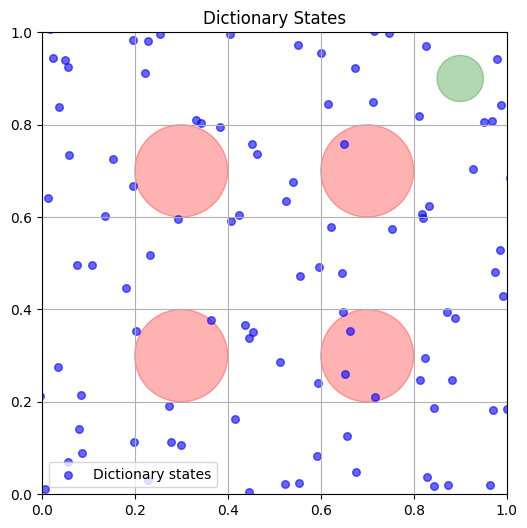

In [23]:
vis_eg.plot_dictionary(agent_eg)

The dictionary covers the distribution of states (i.e. coordinates) sufficiently well, though we some more dense and sparse areas. These are likely due to the difference in actions. We observe a more dense regions around the obstacles, which makes intuitive sense, since different actions could yield to large reward differences. Further, we observe sparser regions in 'free air', since even with the large action noise of ±36 degrees, the reward doesn't change (it is still -1 for the timestep) because no obstacle/goal state is hit. 

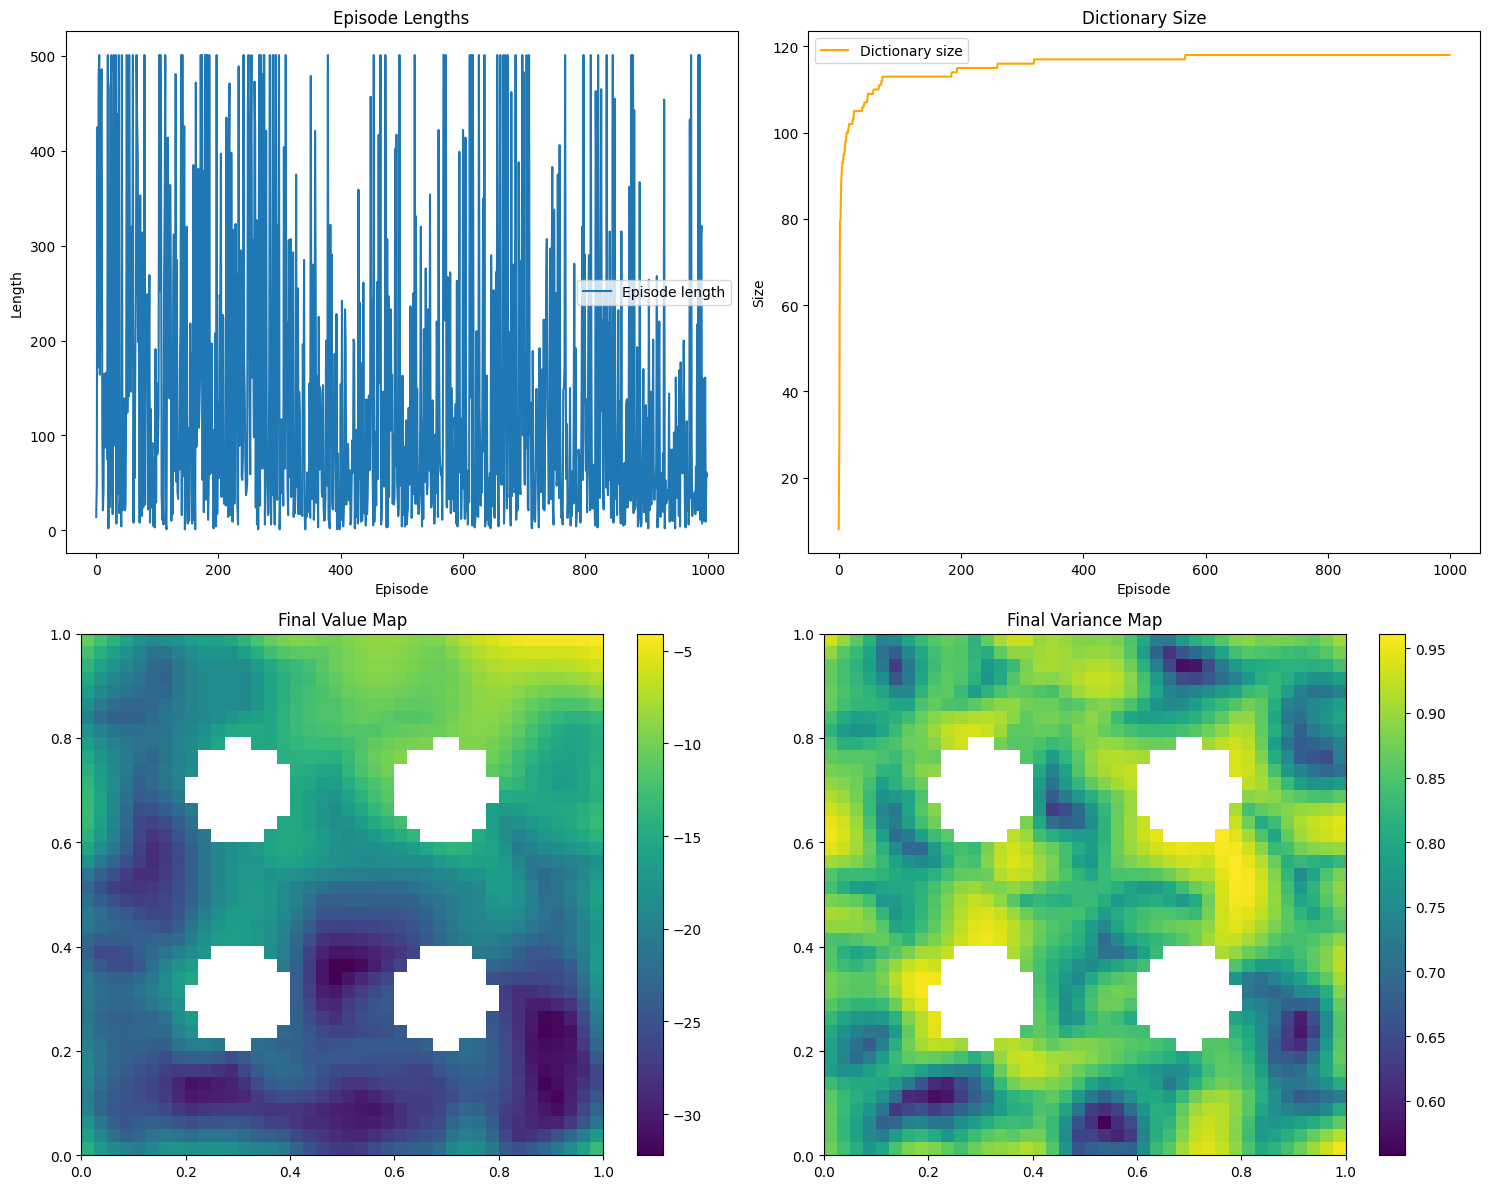

In [62]:
vis_eg.plot_training_progress()

From the value map, we already begin to observe convergence based completely on the Euclidean distance heuristic – states further from the goal have a lower value, whereas states closer to the goal have higher values. We are also beginning to see that the agent has learned to avoid the obstacles, particularly the one on the bottom row.

The variance map also reveals patterns of interest. Larger variances accrue surrounding the obstacle in the direction of the goal state, likely due to the fact that there is significant action noise, so the agent is not confident in the actions it takes around the obstacles as it runs the risk of hitting one even when it points away from it. 

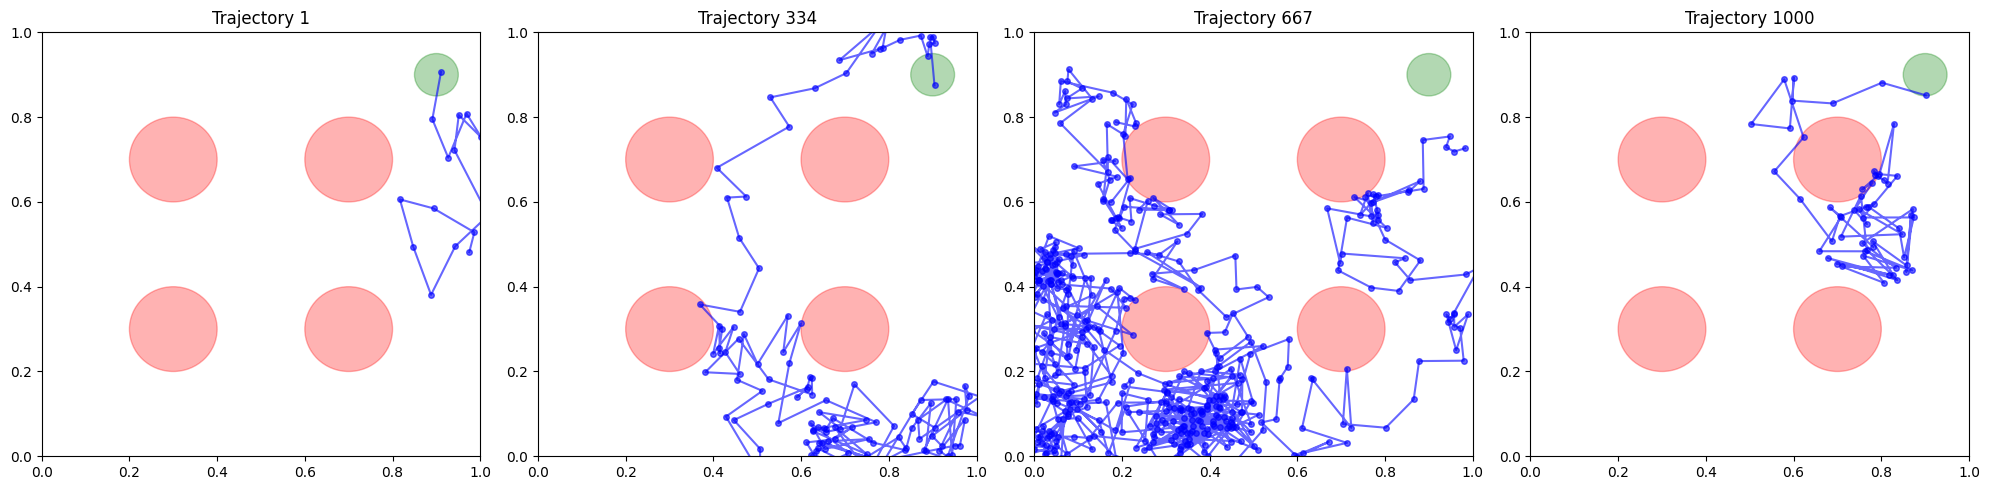

In [22]:
vis_eg.plot_trajectory_evolution(num_trajectories=4)

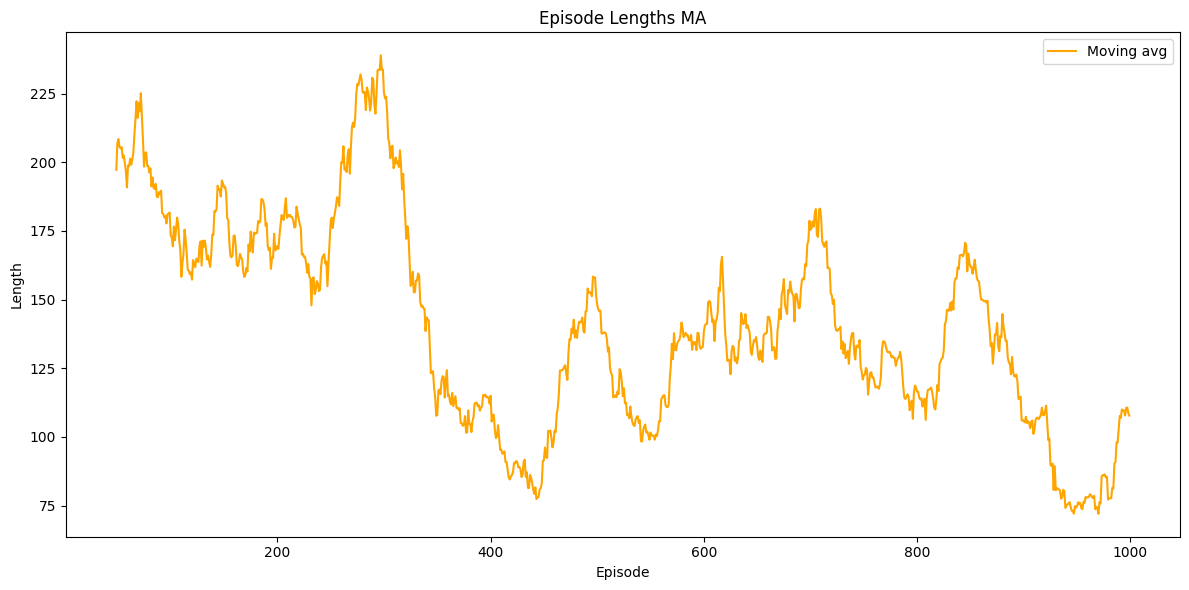

In [66]:
episode_lengths = vis_eg.episode_lengths
dictionary_sizes = vis_eg.dictionary_sizes
dictionary_points = np.array(agent_eg.dictionary_states)
variance_map = vis_eg.variance_maps[-1]

# Moving average window
window = 50
moving_avg = np.convolve(episode_lengths, np.ones(window)/window, mode='valid')

# Create plots
plt.figure(figsize=(12,6))

# Episode lengths with moving average
plt.plot(range(window-1, len(episode_lengths)), moving_avg, label='Moving avg', color='orange')
plt.title('Episode Lengths MA')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.legend()

plt.tight_layout()
plt.show()

While the graph above is not rigorous, in that the start locations of each episode most certainly confound the number of samples until convergence, overall, having performed a linear filter, we observe a negative trend. This may indicate that the agent is beginning to act less randomly, it is able to reach the goal state in some capacity.

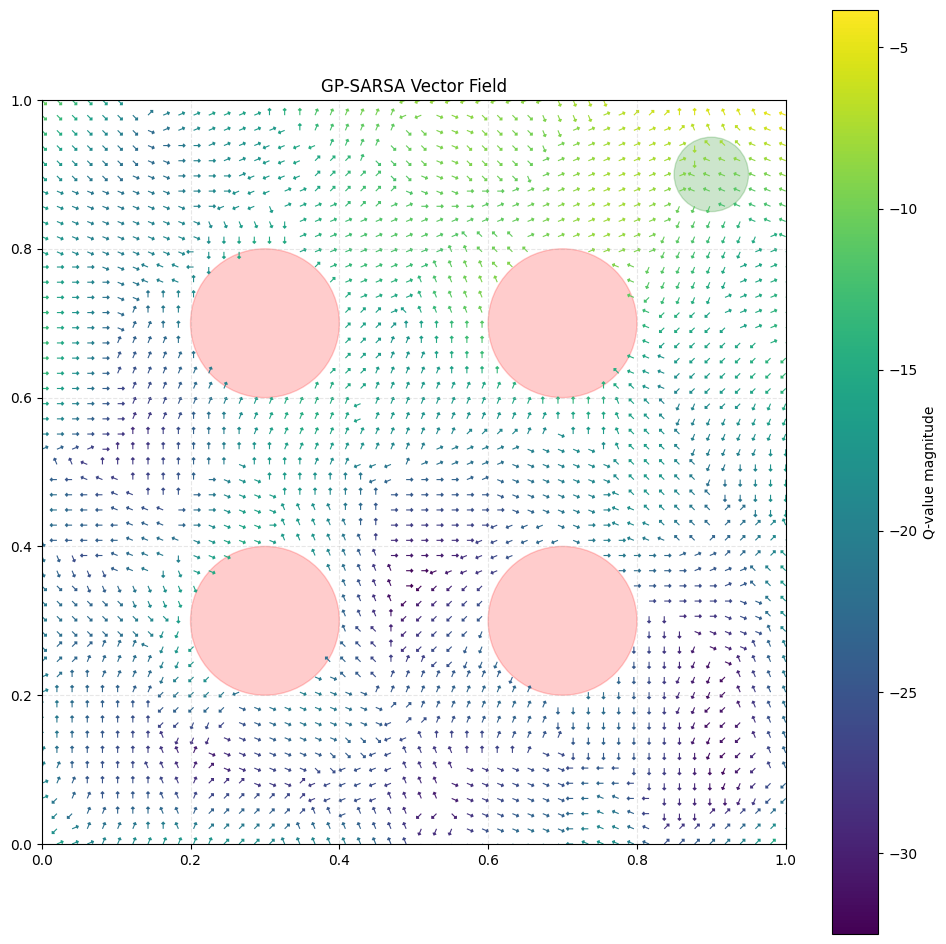

In [94]:
resolution = 50  
X, Y, U, V, magnitudes = create_vector_field(agent_eg, env_eg, resolution)
plot_vector_field(env_eg, X, Y, U, V, magnitudes)
plt.show()

## 7. Conclusion

This implementation of the GP-SARSA agent provides an efficient framework for online reinforcement learning in continuous state-action spaces. By leveraging kernel-based function approximation and incremental updates, the agent can learn and adapt to complex environments without requiring explicit modeling of the dynamics. In the environments where uncertainty quantification is necessary, GP-SARSA is a rather compelling method, capturing insights into agentic behavior not possible without the usage of GPs. 

## 8. References

Engel, Y., Mannor, S., and Meir, R. Reinforcement learning with gaussian processes. In Proceedings of the 22nd International Conference on Machine Learning, ICML '05, pp. 201-208, New York, NY, USA, 2005. Association for Computing Machinery. ISBN 1595931805.